In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
print(os.getcwd())

import time
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import Model
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import warnings
warnings.filterwarnings("ignore")

from dsvdd import *

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score

d:\SourceTree\Autoencoder_SVDD
Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
def metrics_v1(y_test, y_predict):
    result = dict()
    result['acc'] = accuracy_score(y_test, y_predict)
    result['precision'] = precision_score(y_test, y_predict)
    result['Recall'] = recall_score(y_test, y_predict)
    result['F1'] = f1_score(y_test, y_predict)
    result['AUROC'] = roc_auc_score(y_test, y_predict)

    return result


def print_metric(y_test, y_predict):
    result = metrics_v1(y_test, y_predict)
    print('Accuracy         = %.4f ' % (result['acc']))
    print('Precision_score  = %.4f ' % (result['precision']))
    print('Recall_score     = %.4f ' % (result['Recall']))
    print('F1_score         = %.4f ' % (result['F1']))
    print('AUC              = %.4f ' % (result['AUROC']))


def Vanilla_AE(H=5):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=(9,)))
    model.add(keras.layers.Dense(6, activation='relu', use_bias=False))
    model.add(keras.layers.Dense(H, activation='relu', use_bias=False, name='code_layer'))
    model.add(keras.layers.Dense(6, activation='relu', use_bias=False))
    model.add(keras.layers.Dense(9, activation='tanh', use_bias=False))
    return model


# In[3]:


def get_paysim():
    df = pd.read_csv('D:\SourceTree\THESIS_2020-2021_CODE\AESVDD\paysim_dataset\paysim.csv')

    df['hour'] = df['step'] % 24
    df['day'] = (df['step'] / 24 ).apply(np.ceil)
    df['sin_hour'] = np.sin(2*np.pi*df.hour/24)
    df['type'] = LabelEncoder().fit_transform(df['type'])
    df['nameDest'] = LabelEncoder().fit_transform(df['nameDest'])
    
    features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest']
    df[features] = StandardScaler().fit_transform(df.loc[:, features].values)
    
    features_train = ['nameDest', 'oldbalanceOrg', 'newbalanceOrig', 'type', 'amount', 'sin_hour', 'day', 'step', 'hour']
    targets = ['isFraud']
    X = df.loc[:, features_train].values
    y = df.loc[:, targets].values
    X = X - (X.max(0)+X.min(0))/2
    X = X/X.max(axis=0) 
    y = y.reshape(-1,)
    y = np.where(y == 1, -1, 1)
    return X, y

In [3]:
print('-----------   start get dataset     -----------')
X, y = get_paysim()
print('-----------   get dataset  Sucessful -----------')

-----------   start get dataset     -----------
-----------   get dataset  Sucessful -----------


In [4]:
##ratio train-val-test 0.6 0.2 0.2
X_train, X_test , y_train, y_test = train_test_split(X, y, train_size=8000, test_size=2000)
X_train, X_val , y_train, y_val = train_test_split(X_train, y_train, train_size=0.75)

In [5]:
tf.reset_default_graph()
AE_model = Vanilla_AE(H=5)


#pre_train_AE (not required)
AE_model.compile(optimizer='adam', loss='mse')
print("pre-train AE")
AE_model.fit(X_train, X_train, epochs=2, batch_size=128, validation_data=(X_test, X_test), verbose=1)


inputs = AE_model.input
outputs = AE_model.get_layer(name="code_layer").output
encoder = Model(inputs = inputs, outputs = outputs)


# build model and DeepSVDD
svdd_soft = DeepSVDD(encoder, input_shape=(9,), representation_dim=5, objective='hard', nu=0.035, batch_size=128, lr=1e-4)

t0 = time.time()
hisory_soft = svdd_soft.fit(X_train, X_val, y_val, epochs=5, verbose=True)
print('Train time:', time.time() - t0)



pre-train AE
Train on 6000 samples, validate on 2000 samples
Epoch 1/2
6000/6000 [==============================] - 0s 76us/sample - loss: 0.5400 - val_loss: 0.4782
Epoch 2/2
100%|██████████| 47/47 [00:00<00:00, 412.29it/s]
Epoch:   0 AUROC: 0.649
100%|██████████| 47/47 [00:00<00:00, 796.64it/s]
Epoch:   1 AUROC: 0.595
100%|██████████| 47/47 [00:00<00:00, 712.15it/s]
Epoch:   2 AUROC: 0.576
100%|██████████| 47/47 [00:00<00:00, 701.52it/s]
Epoch:   3 AUROC: 0.571
100%|██████████| 47/47 [00:00<00:00, 681.20it/s]
Epoch:   4 AUROC: 0.489
Train time: 0.6649985313415527


In [6]:
# test DeepSVDD
t0 = time.time()
score = svdd_soft.predict(X_test)
auc = roc_auc_score(y_test, -score)
print('Test time:', time.time() - t0)
print("---------------- Dataset---------------")
print("Train_set size:   ", len(X_train))
print("Test_set size:    ", len(X_test))
print("nu:    ", svdd_soft.nu)
print('AUROC: %.4f' % auc)

Test time: 0.023998498916625977
---------------- Dataset---------------
Train_set size:    6000
Test_set size:     2000
nu:     0.035
AUROC: 0.9850


In [7]:
label = svdd_soft.predict_label(X_test)

In [147]:
score_temp = np.msort(score)
threshold = score_temp[score.size - (int)(score.size * 0.05)]

In [11]:
label

array([-1, -1, -1, ..., -1, -1, -1])

In [109]:
score

array([0.0702428 , 0.10530061, 0.07037321, ..., 0.23515034, 0.13420303,
       0.32035506], dtype=float32)

In [148]:
score_label = np.where(score > threshold, -1, 1)

In [132]:
score_label

array([1, 1, 1, ..., 1, 1, 1])

In [137]:
np.unique(score_label, return_counts=True)

(array([-1,  1]), array([  99, 1901], dtype=int64))

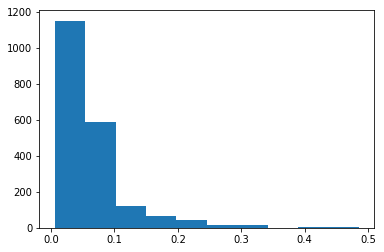

In [135]:
import numpy as np
import matplotlib.pyplot as plt
mu, sigma = 200, 25
x = mu + sigma*np.random.randn(10000)
n, bins, patches = plt.hist(score)
plt.show()

In [32]:
np.unique(score > 0.1, return_counts=True)

(array([False,  True]), array([ 918, 1082], dtype=int64))

In [8]:
roc_auc_score(y_test, -score, average=None)

0.984992496248124

In [9]:
roc_auc_score(y_test, label, average=None)

0.9829914957478739

In [19]:
temp = -score[0:10] > 0

In [79]:
y[-score[0]]

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [141]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score

In [11]:
accuracy_score(y_test, label)

0.966